In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [4]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('NKG Historical Data.csv', sep=",")
df1=df.reset_index()['Price']

In [5]:
df1 = df1.str.replace(',', '', regex=True).astype(float)

# 3. Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [6]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [7]:
print(train_data.shape, test_data.shape)

(1181, 1) (132, 1)


In [8]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [9]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
train_last_windowsize = train_data[-time_step-1:]
test_data_extended = np.concatenate((train_last_windowsize, test_data), axis=0)
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data_extended, time_step)

In [10]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],1 ,X_test.shape[1])

In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(ytest.shape)

(1080, 1, 100)
(1080,)
(132, 1, 100)
(132,)


In [12]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(1,100)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

# Fit model
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 [==============================] - 9s 11ms/step - loss: 0.1161
Epoch 2/100
17/17 [==============================] - 0s 11ms/step - loss: 0.0224
Epoch 3/100
17/17 [==============================] - 0s 10ms/step - loss: 0.0164
Epoch 4/100
17/17 [==============================] - 0s 11ms/step - loss: 0.0109
Epoch 5/100
17/17 [==============================] - 0s 11ms/step - loss: 0.0061
Epoch 6/100
17/17 [==============================] - 0s 11ms/step - loss: 0.0037
Epoch 7/100
17/17 [==============================] - 0s 10ms/step - loss: 0.0028
Epoch 8/100
17/17 [==============================] - 0s 11ms/step - loss: 0.0023
Epoch 9/100
17/17 [==============================] - 0s 10ms/step - loss: 0.0020
Epoch 10/100
17/17 [==============================] - 0s 13ms/step - loss: 0.0017
Epoch 11/100
17/17 [==============================] - 0s 12ms/step - loss: 0.0015
Epoch 12/100
17/17 [==============================] - 0s 12ms/step - loss: 0.0014
Epoch 13/100
17/17 [=====

In [13]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

5/5 [==============================] - 0s 4ms/step


In [14]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [15]:
# Actual values of the test set
y_test1 = scaler.inverse_transform(ytest.reshape(-1, 1))

# RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test1)**2))
print('RMSE:', test_rmse)

# MAPE
mape_test = np.mean(np.abs((y_test1 - y_pred) / y_test1)) * 100
print('MAPE:', mape_test)

# MAE
mae_test = np.mean(np.abs(y_test1 - y_pred))
print("MAE:", mae_test)

RMSE: 175.17833954880058
MAPE: 2.8006983935744714
MAE: 126.30759092388728


In [16]:
# Chuyển đổi dữ liệu kiểm tra thành danh sách
x_input = test_data[30:].reshape(1, -1)

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_90 = []
n_steps = 100
i = 0

while i < 90:
    if len(temp_input) > n_steps: # Use n_steps instead of a hardcoded value
        # Chuẩn bị dữ liệu đầu vào mới
        x_input = np.array(temp_input[-n_steps:])  # Use n_steps to ensure consistency
        print("{} day input {}".format(i, x_input))

        x_input = x_input.reshape((1, 1, n_steps))

        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))

        # Thêm giá trị dự đoán vào danh sách tạm thời
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:] # Keep the list length manageable

        lst_output_90.extend(yhat.tolist())
        i += 1
    else:
        # Pad the input if it's too short
        x_input = np.pad(temp_input, (0, n_steps - len(temp_input)), 'constant').reshape((1, 1, n_steps))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])

        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))

        lst_output_90.extend(yhat.tolist())
        i += 1

0 day input [0.02592294 0.02670251 0.02623429 0.02763894 0.02810953 0.02810953
 0.02810953 0.02842088 0.02842088 0.02967104 0.03029374 0.03029374
 0.02904596 0.02904596 0.0277958  0.02732759 0.02888909 0.02888909
 0.03060747 0.02810953 0.03123255 0.03138703 0.02873223 0.02935731
 0.03232584 0.03123255 0.02654802 0.02685937 0.02717072 0.0277958
 0.02888909 0.02920282 0.02842088 0.02685937 0.02701624 0.02717072
 0.02592294 0.02576608 0.02795267 0.02904596 0.02967104 0.0277958
 0.02545473 0.02982552 0.02967104 0.03123255 0.02888909 0.02982552
 0.02998239 0.02982552 0.02967104 0.02967104 0.02826402 0.0277958
 0.02732759 0.02701624 0.02654802 0.02888909 0.03357362 0.03373048
 0.0368535  0.03591707 0.03701036 0.03529199 0.03529199 0.03747858
 0.03622842 0.03794679 0.04388148 0.04669314 0.04762957 0.04528612
 0.04528612 0.05028438 0.04997065 0.05543712 0.05293918 0.04606806
 0.04606806 0.04528612 0.04528612 0.04341326 0.04263132 0.04106981
 0.04450656 0.04388148 0.04544299 0.04434969 0.045754

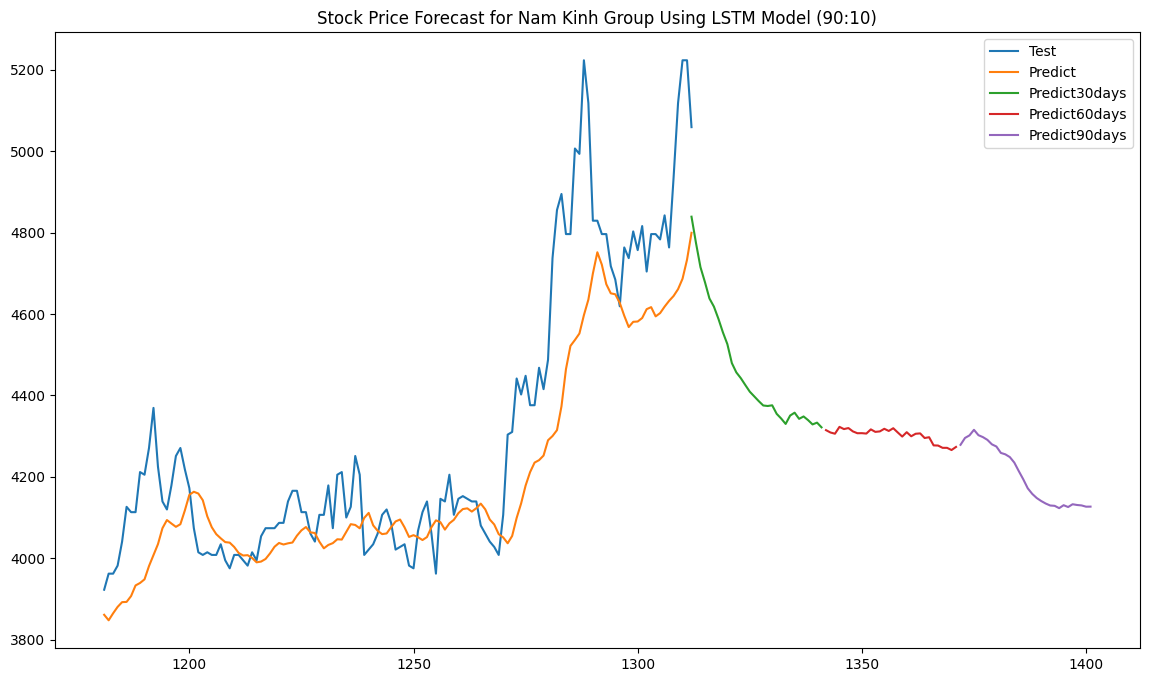

In [17]:
plt.figure(figsize=(14, 8))

# Vẽ dữ liệu kiểm tra (test_data)
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + len(test_data), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

# Vẽ dữ liệu dự đoán cho tập kiểm tra (y_pred)
test_pred_index = pd.RangeIndex(start=train_size, stop=train_size + len(test_data), step=1)
plt.plot(test_pred_index, y_pred, label='Predict')

# Vẽ dự đoán 30 ngày
predict_index_30 = pd.RangeIndex(start=len(df)-1, stop=len(df) + 29, step=1)
plt.plot(predict_index_30, scaler.inverse_transform(lst_output_90[:30]), label='Predict30days')

# Vẽ dự đoán 60 ngày
predict_index_60 = pd.RangeIndex(start=len(df)+29, stop=len(df) + 59, step=1)
plt.plot(predict_index_60, scaler.inverse_transform(lst_output_90[30:60]), label='Predict60days')

# Vẽ dự đoán 90 ngày
predict_index_90 = pd.RangeIndex(start=len(df)+59, stop=len(df) + 89, step=1)
plt.plot(predict_index_90, scaler.inverse_transform(lst_output_90[60:]), label='Predict90days')

# Thêm chú thích và hiển thị đồ thị
plt.title('Stock Price Forecast for Nam Kinh Group Using LSTM Model (90:10)')
plt.legend(['Test', 'Predict', 'Predict30days', 'Predict60days', 'Predict90days'])
plt.show()


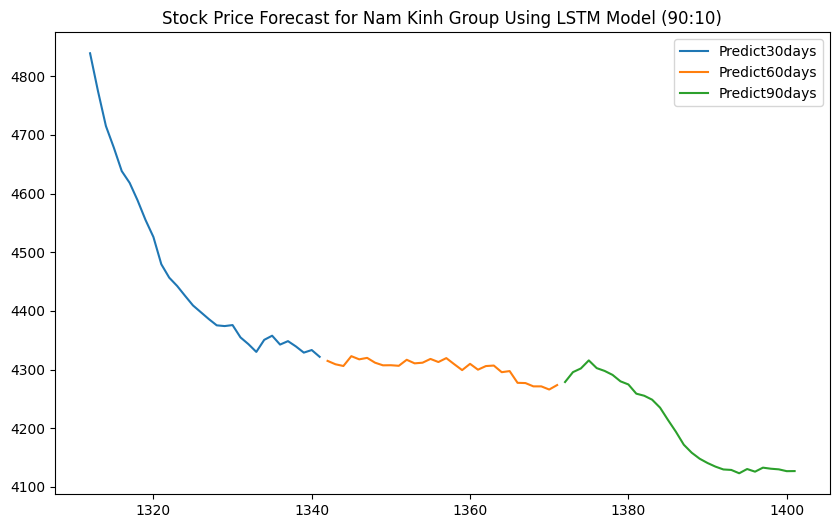

In [18]:
plt.figure(figsize=(10, 6))

# Vẽ dự đoán 30 ngày
predict_index_30 = pd.RangeIndex(start=len(df)-1, stop=len(df) + 29, step=1)
plt.plot(predict_index_30, scaler.inverse_transform(lst_output_90[:30]), label='Predict30days')

# Vẽ dự đoán 60 ngày
predict_index_60 = pd.RangeIndex(start=len(df)+29, stop=len(df) + 59, step=1)
plt.plot(predict_index_60, scaler.inverse_transform(lst_output_90[30:60]), label='Predict60days')

# Vẽ dự đoán 90 ngày
predict_index_90 = pd.RangeIndex(start=len(df)+59, stop=len(df) + 89, step=1)
plt.plot(predict_index_90, scaler.inverse_transform(lst_output_90[60:]), label='Predict90days')

plt.title('Stock Price Forecast for Nam Kinh Group Using LSTM Model (90:10)')
plt.legend(['Predict30days', 'Predict60days', 'Predict90days'])
plt.show()